<a href="https://colab.research.google.com/github/dTenebrae/nlp/blob/main/lesson5/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1

**Написать теггер на данных с руским языком**
1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбмнации
2. написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов
3. сравнить все реализованные методы сделать выводы


## Загрузка данных и импорт библиотек

In [1]:
!pip install pyconll

In [54]:
import pyconll
from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import warnings
warnings.simplefilter("ignore")

In [3]:
from IPython.display import clear_output

In [4]:
!mkdir datasets

In [5]:
!wget -O ./datasets/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
!wget -O ./datasets/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu
clear_output()

In [6]:
full_train = pyconll.load_from_file('datasets/ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('datasets/ru_syntagrus-ud-dev.conllu')

## Преобразуем данные

In [7]:
%%time
train_result = []
for sentence in full_train:
    sent_list = []
    for token in sentence:
        sent_list.append((token.form, token.upos))
    train_result.append(sent_list)

test_result = []
for sentence in full_test:
    sent_list = []
    for token in sentence:
        sent_list.append((token.form, token.upos))
    test_result.append(sent_list)

test_sent = []
for sentence in full_test:
    sent_list = []
    for token in sentence:
        sent_list.append(token.form)
    test_sent.append(sent_list)

CPU times: user 727 ms, sys: 43 ms, total: 770 ms
Wall time: 769 ms


In [8]:
len(train_result), len(test_result)

(48814, 6584)

## Taggers

In [9]:
unigram_tagger = UnigramTagger(train_result)
unigram_tagger.evaluate(test_result)

0.8772537323492737

In [10]:
bigram_tagger = BigramTagger(train_result, backoff=unigram_tagger)
bigram_tagger.evaluate(test_result)

0.8829828463586425

In [11]:
trigram_tagger = TrigramTagger(train_result, backoff=bigram_tagger)
trigram_tagger.evaluate(test_result)

0.882081353418933

In [12]:
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff


backoff = UnigramTagger(train_result)
tag = backoff_tagger(train_result,  
                     [BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
tag.evaluate(test_result) 

0.882081353418933

In [13]:
bigram_tagger.tag(test_sent[2])

[('Это', 'PRON'),
 ('связано', 'VERB'),
 ('с', 'ADP'),
 ('тем', 'PRON'),
 (',', 'PUNCT'),
 ('что', 'SCONJ'),
 ('работа', 'NOUN'),
 ('каких-то', 'DET'),
 ('инструкций', 'NOUN'),
 ('алгоритма', None),
 ('может', 'VERB'),
 ('быть', 'AUX'),
 ('зависима', None),
 ('от', 'ADP'),
 ('других', 'ADJ'),
 ('инструкций', 'NOUN'),
 ('или', 'CCONJ'),
 ('результатов', 'NOUN'),
 ('их', 'PRON'),
 ('работы', 'NOUN'),
 ('.', 'PUNCT')]

In [14]:
train_tok = []
train_label = []
for sent in train_result:
    for tok in sent:
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in test_result:
    for tok in sent:
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [15]:
cnt = Counter(train_label)
cnt

Counter({'ADJ': 85589,
         'ADP': 81963,
         'ADV': 44101,
         'AUX': 7535,
         'CCONJ': 30432,
         'DET': 21968,
         'INTJ': 78,
         'NOUN': 214497,
         'NO_TAG': 1047,
         'NUM': 13746,
         'PART': 26638,
         'PRON': 38438,
         'PROPN': 32401,
         'PUNCT': 157989,
         'SCONJ': 16219,
         'SYM': 840,
         'VERB': 97670,
         'X': 375})

In [16]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)
test_enc_labels = le.transform(test_label)

**Логистическая регрессия в связке с векторайзерами**

In [17]:
h_vectorizer = HashingVectorizer(ngram_range=(1, 5), analyzer='char', n_features=100)
cnt_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [18]:
X_train_h = h_vectorizer.fit_transform(train_tok)
X_test_h = h_vectorizer.transform(test_tok)

X_train_c = cnt_vectorizer.fit_transform(train_tok)
X_test_c = cnt_vectorizer.transform(test_tok)

X_train_t = tfidf_vectorizer.fit_transform(train_tok)
X_test_t = tfidf_vectorizer.transform(test_tok)

In [19]:
lr_h = LogisticRegression(random_state=0, max_iter=100)
lr_c = LogisticRegression(random_state=0, max_iter=100)
lr_t = LogisticRegression(random_state=0, max_iter=100)

lr_h.fit(X_train_h, train_enc_labels)
lr_c.fit(X_train_c, train_enc_labels)
lr_t.fit(X_train_t, train_enc_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
y_test_pred_h = lr_h.predict(X_test_h)
y_train_pred_h = lr_h.predict(X_train_h)

y_test_pred_c = lr_c.predict(X_test_c)
y_train_pred_c = lr_c.predict(X_train_c)

y_test_pred_t = lr_t.predict(X_test_t)
y_train_pred_t = lr_t.predict(X_train_t)

acc_h = accuracy_score(test_enc_labels, y_test_pred_h)
acc_c = accuracy_score(test_enc_labels, y_test_pred_c)
acc_t = accuracy_score(test_enc_labels, y_test_pred_t)
print(f'Hash accuracy: {acc_h:.3f}\nCount accuracy: {acc_c:.3f}\nTfidf accuracy: {acc_t:.3f}')

Hash accuracy: 0.686
Count accuracy: 0.672
Tfidf accuracy: 0.674


## Посмотрим на качество работы моделей по каждому классу

In [21]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred, digits=3):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred, digits=digits))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred, digits=digits))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [22]:
get_classification_report(train_enc_labels, y_train_pred_h, test_enc_labels, y_test_pred_h)

TRAIN

              precision    recall  f1-score   support

           0      0.566     0.449     0.501     85589
           1      0.767     0.878     0.819     81963
           2      0.541     0.245     0.337     44101
           3      0.824     0.973     0.893      7535
           4      0.853     0.969     0.908     30432
           5      0.588     0.564     0.576     21968
           6      0.000     0.000     0.000        78
           7      0.547     0.731     0.626    214497
           8      1.000     1.000     1.000      1047
           9      0.717     0.634     0.673     13746
          10      0.734     0.601     0.661     26638
          11      0.533     0.558     0.545     38438
          12      0.500     0.069     0.122     32401
          13      0.995     1.000     0.997    157989
          14      0.786     0.883     0.832     16219
          15      0.999     0.908     0.951       840
          16      0.622     0.517     0.565     97670
          17      0.

In [23]:
get_classification_report(train_enc_labels, y_train_pred_c, test_enc_labels, y_test_pred_c)

TRAIN

              precision    recall  f1-score   support

           0      0.974     0.507     0.667     85589
           1      0.987     0.489     0.654     81963
           2      0.954     0.830     0.887     44101
           3      0.845     0.876     0.860      7535
           4      0.891     0.211     0.341     30432
           5      0.901     0.720     0.801     21968
           6      0.000     0.000     0.000        78
           7      0.989     0.783     0.874    214497
           8      0.000     0.000     0.000      1047
           9      0.915     0.681     0.781     13746
          10      0.986     0.761     0.859     26638
          11      0.829     0.861     0.845     38438
          12      0.947     0.357     0.518     32401
          13      0.403     1.000     0.574    157989
          14      0.815     0.867     0.840     16219
          15      0.000     0.000     0.000       840
          16      0.980     0.534     0.692     97670
          17      0.

In [24]:
get_classification_report(train_enc_labels, y_train_pred_t, test_enc_labels, y_test_pred_t)

TRAIN

              precision    recall  f1-score   support

           0      0.973     0.483     0.646     85589
           1      0.986     0.489     0.654     81963
           2      0.954     0.829     0.887     44101
           3      0.845     0.876     0.860      7535
           4      0.889     0.211     0.340     30432
           5      0.902     0.723     0.803     21968
           6      0.000     0.000     0.000        78
           7      0.989     0.816     0.894    214497
           8      0.000     0.000     0.000      1047
           9      0.915     0.684     0.783     13746
          10      0.970     0.766     0.856     26638
          11      0.829     0.860     0.844     38438
          12      0.950     0.355     0.517     32401
          13      0.406     1.000     0.577    157989
          14      0.817     0.838     0.827     16219
          15      0.000     0.000     0.000       840
          16      0.979     0.511     0.672     97670
          17      0.

Как мы видим, разница в работе разных векторайзеров не слишком сказывается на итоговой метрике, однако, если оценить качество работы по каждому классу, то различие достаточно значимо

# Задание 2

много дополнительных датасетов на русском языке

https://natasha.github.io/corus/  
https://github.com/natasha/corus

мы будем использовать данные http://www.labinform.ru/pub/named_entities/

**Проверить насколько хорошо работает NER**

1. взять нер из nltk
2. проверить deeppavlov
3. написать свой нер попробовать разные подходы:
* передаём в сетку токен и его соседей
* передаём в сетку только токен

4. сделать выводы по вашим экспериментам какой из подходов успешнее справляется

при обучении своего нера незабудьте разделить выборку

In [25]:
!pip install corus
!pip install razdel
!pip install nltk
clear_output()

In [26]:
import corus
from corus import load_ne5
from razdel import tokenize
import nltk

In [27]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
clear_output()

In [28]:
!wget http://www.labinform.ru/pub/named_entities/collection5.zip
clear_output()

In [ ]:
!unzip collection5.zip
clear_output()

In [30]:
!rm collection5.zip

In [31]:
dir = 'Collection5/'
records = load_ne5(dir)

## Подготовка данных

In [32]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [33]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])

In [34]:
df_words['tag'].value_counts()

OUT         219214
PER          21200
ORG          13651
LOC           4568
GEOPOLIT      4356
MEDIA         2482
Name: tag, dtype: int64

In [35]:
df_words.head()

,word,tag
0,Премьер-министром,OUT
1,Таиланда,GEOPOLIT
2,впервые,OUT
3,стала,OUT
4,женщина,OUT


## Построим модель

In [36]:
import tensorflow as tf

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import (Dense, 
                                     Embedding, 
                                     GlobalAveragePooling1D, 
                                     GlobalMaxPooling1D, 
                                     Conv1D, 
                                     GRU, 
                                     LSTM, 
                                     Dropout, 
                                     Input,
                                     TimeDistributed,
                                     Bidirectional)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow.keras.backend as K
from sklearn import model_selection, preprocessing, linear_model
from tensorflow.keras.utils import plot_model

In [37]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.transform(valid_y)

In [38]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
# def custom_standardization(input_data):
#     return input_data

vocab_size = 30000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

**Посмотрим на модель, представленную на уроке**

In [48]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [49]:
mmodel = modelNER()

In [50]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

**Создадим функции метрик для модели**

In [44]:

def recall_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = TP / (Positives+K.epsilon())    
    return recall 


def precision_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = TP / (Pred_Positives+K.epsilon())
    return precision 

def custom_f1(y_true, y_pred):    
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [51]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', custom_f1, recall_m, precision_m])

In [52]:
hist = mmodel.fit(train_data, validation_data=valid_data, epochs=20, callbacks=[es_callback])

Epoch 1/20
12444/12444 [==============================] - 55s 4ms/step - loss: 0.3093 - accuracy: 0.9139 - custom_f1: 1.1676 - recall_m: 1.1566 - precision_m: 1444873.0000 - val_loss: 0.2257 - val_accuracy: 0.9389 - val_custom_f1: 1.0378 - val_recall_m: 1.0448 - val_precision_m: 1.0316
Epoch 2/20
12444/12444 [==============================] - 53s 4ms/step - loss: 0.1413 - accuracy: 0.9622 - custom_f1: 1.0328 - recall_m: 1.0396 - precision_m: 1.0267 - val_loss: 0.2344 - val_accuracy: 0.9413 - val_custom_f1: 1.1246 - val_recall_m: 1.1336 - val_precision_m: 1.1164
Epoch 3/20
12444/12444 [==============================] - 53s 4ms/step - loss: 0.1249 - accuracy: 0.9652 - custom_f1: 1.0318 - recall_m: 1.0398 - precision_m: 1.0245 - val_loss: 0.2568 - val_accuracy: 0.9411 - val_custom_f1: 1.1958 - val_recall_m: 1.2055 - val_precision_m: 1.1868
Epoch 4/20
12444/12444 [==============================] - 53s 4ms/step - loss: 0.1193 - accuracy: 0.9660 - custom_f1: 1.0325 - recall_m: 1.0404 - preci

In [53]:
mmodel.summary()

Model: "model_ner_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1920000   
_________________________________________________________________
global_max_pooling1d_1 (Glob multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  19500     
_________________________________________________________________
dense_4 (Dense)              multiple                  15050     
_________________________________________________________________
dense_5 (Dense)              multiple                  690       
Total params: 1,955,240
Trainable params: 1,955,240
Non-trainable params: 0
_________________________________________________________________


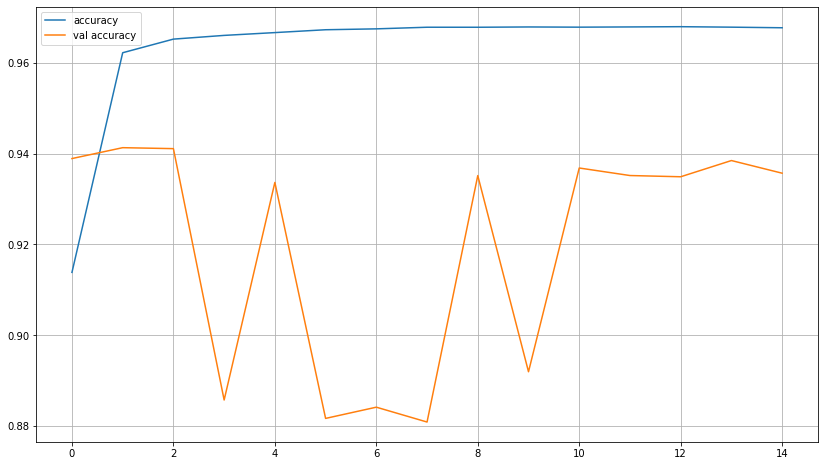

In [62]:
plt.figure(figsize=(14, 8))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [67]:
class model_no_skip_NER(tf.keras.Model):
    def __init__(self):
        super(model_no_skip_NER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x = self.gPool(x)
        
        fc_x = self.fc1(x)
        fc_x = self.fc2(fc_x)
        prob = self.fc3(fc_x)
        return prob

In [68]:
no_skip_model = model_no_skip_NER()

In [69]:
no_skip_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy', custom_f1, recall_m, precision_m])

In [71]:
hist = no_skip_model.fit(train_data, validation_data=valid_data, epochs=20, callbacks=[es_callback])

Epoch 1/20
12444/12444 [==============================] - 68s 4ms/step - loss: 0.3110 - accuracy: 0.9133 - custom_f1: 1.1692 - recall_m: 1.1580 - precision_m: 1484249.3750 - val_loss: 0.2279 - val_accuracy: 0.9389 - val_custom_f1: 1.0998 - val_recall_m: 1.1074 - val_precision_m: 1.0930
Epoch 2/20
12444/12444 [==============================] - 52s 4ms/step - loss: 0.1429 - accuracy: 0.9618 - custom_f1: 1.0349 - recall_m: 1.0416 - precision_m: 1.0288 - val_loss: 0.3274 - val_accuracy: 0.8952 - val_custom_f1: 1.0334 - val_recall_m: 1.0419 - val_precision_m: 1.0257
Epoch 3/20
12444/12444 [==============================] - 52s 4ms/step - loss: 0.1251 - accuracy: 0.9651 - custom_f1: 1.0332 - recall_m: 1.0410 - precision_m: 1.0260 - val_loss: 0.3167 - val_accuracy: 0.8961 - val_custom_f1: 1.1193 - val_recall_m: 1.1286 - val_precision_m: 1.1108
Epoch 4/20
12444/12444 [==============================] - 52s 4ms/step - loss: 0.1195 - accuracy: 0.9661 - custom_f1: 1.0336 - recall_m: 1.0416 - preci

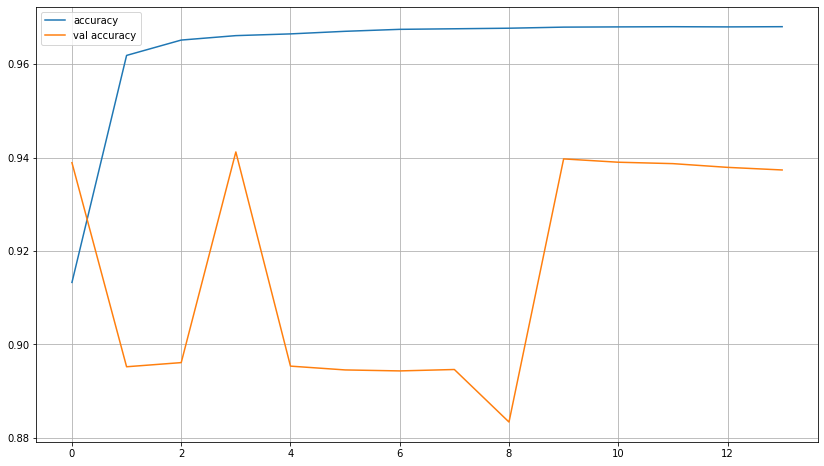

In [72]:
plt.figure(figsize=(14, 8))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

## NLTK

In [46]:
records = load_ne5(dir)
rec_list = list(records)
sample = rec_list[0].text

In [47]:
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sample))) if hasattr(chunk, 'label') }

{('Апхисит Ветчачива', 'PERSON'),
 ('Демократической', 'PERSON'),
 ('Йинглак Чинават', 'PERSON'),
 ('Таиланд', 'PERSON'),
 ('Таиланда', 'ORGANIZATION'),
 ('Таксин Чинават', 'PERSON'),
 ('Таксина Чинавата', 'PERSON'),
 ('Чинават', 'ORGANIZATION'),
 ('Чинават', 'PERSON')}

## Проверим работу **Deeppavlov**

In [ ]:
# установка deeppavlov

!pip uninstall -y tensorflow tensorflow-gpu
!pip install numpy scipy librosa unidecode inflect librosa transformers
!pip install deeppavlov
clear_output()

In [ ]:
!python -m deeppavlov install squad_bert
!python -m deeppavlov install ner_ontonotes
clear_output()

In [2]:
import deeppavlov
from deeppavlov import configs, build_model

In [ ]:
# deeppavlov_ner = build_model(configs.ner.ner_bert_ent_and_type_rus, download=True)

In [3]:
import corus
from corus import load_ne5

In [4]:
dir = 'Collection5/'
records = load_ne5(dir)
rec_list = list(records)
sample = rec_list[0].text

In [5]:
sample

'Премьер-министром Таиланда впервые стала женщина\r\n\r\nПарламент Таиланда избрал на пост премьер-министра Йинглак Чинават, сестру бывшего главы правительства Таксина Чинавата, сообщает Agence France-Presse. 44-летняя Йинглак Чинават стала первой в истории Таиланда женщиной, занявшей пост премьер-министра\r\n\r\nДля избрания Йинглак Чинават было необходимо получить 251 голос в парламенте, состоящем из 500 депутатов. Партия "Пхыа Тхаи", которую возглавляет Чинават, даже без учета партнеров по коалиции занимает в парламенте 265 мест.\r\n\r\nОппозиционная партия "Пхыа Тхаи" с большим перевесом победила на парламентских выборах, прошедших в начале июля 2011 года. Представитель Демократической партии Апхисит Ветчачива, занимавший пост премьера с 2008 года, после объявления результатов выборов подал в отставку. В парламенте нового созыва Демократическая партия получила лишь 159 мест.\r\n\r\nЙинглак Чинават - сестра Таксина Чинавата, занимавшего пост премьер-министра Таиланда с 2001 по 2006 

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

In [9]:
import spacy
from spacy import displacy
nlp = spacy.load('ru_core_news_sm')
text = nlp(sample)
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
ner_model = build_model(configs.ner.ner_ontonotes_bert_mult_torch, download=True)

In [7]:
res = ner_model([sample])

In [8]:
for word, ner in zip(res[0][0], res[1][0]):
    if ner != "O":
        print(f"{word:<25}{ner:>25}")

Таиланда                                     B-GPE
Парламент                                    B-ORG
Таиланда                                     B-GPE
Йинглак                                   B-PERSON
Чинават                                   I-PERSON
Таксина                                   B-PERSON
Чинавата                                  I-PERSON
Agence                                       B-ORG
France                                       I-ORG
-                                            I-ORG
Presse                                       I-ORG
44                                          B-DATE
-                                           I-DATE
летняя                                      I-DATE
Йинглак                                   B-PERSON
Чинават                                   I-PERSON
первой                                   B-ORDINAL
Таиланда                                     B-GPE
Йинглак                                   B-PERSON
Чинават                        

В выдаче этой модели теги указываются с учетом отношений, то есть B-PERSON - слово в начале тэга, I-PERSON внутри тэга